# [AHA! Activity Health Analytics](http://casas.wsu.edu/)
[Center for Advanced Studies of Adaptive Systems (CASAS)](http://casas.wsu.edu/)

[Washington State University](https://wsu.edu)
# L2-4 Data Aggregation

Learner objectives for this lesson:
* Learn about aggregating data 
* Perform data aggregation

## Acknowledgments
Content used in this lesson is based upon information in the following sources:
* [Pandas website](http://pandas.pydata.org/)
* Python for Data Analysis by Wes McKinney

## Data Aggregation Overview
Gathering and summarizing information, perhaps in preparation for statistical analysis or visualization, is called *data aggregation*. For example, suppose you want to investigate the similarities/differences amongst patients in a clinical setting. Suppose specific attributes you are interested in include medical condition, age, and gender. You might *group* the data into two groups: male and female. By grouping the data based on a variable, such as gender, you are aggregating the data. The grouping allows you to then create a bar chart representing the frequency of each medical condition present in each group, or perform hypothesis testing to see if there is a significant age difference between the two groups. 

Data aggregation typically follows a "split, apply, combine" process:
* Split the data into groups based on some criteria
    * Perform *group by* operations
    * Select or slice data to form a subset
    * Example: Group a data frame by rows (axis 0) or by columns (axis 1)
* Apply a function to each group independently, producing a new value
    * Compute summary statistics (aggregation)
        * Example: Count the size of each group
        * Example: Compute mean, standard deviation, custom stats, etc.
    * Transform the data in the group (transformation)
        * Example: Standardizing data (z-score) within each group
        * Example: Filling missing data with a value derived from each group
    * Discard some groups (filtration)
        * Example: Discarding data that belongs to groups with only a few members
        * Example: Filtering out data based on the group sum or mean
* Combine the results of the function applications into a data structure
    * Example: A series with index corresponding to data frame column names and values representing the column means
    
<img src="http://blog.yhat.com/static/img/split-apply-combine.jpg" width="500">
(image from [http://blog.yhat.com/static/img/split-apply-combine.jpg](http://blog.yhat.com/static/img/split-apply-combine.jpg))
    
### Pandas GroupBy
In the split step, we want to divide a dataset into a mapping of group names to group data. With the Pandas [`groupby()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) function, we can divide a data frame into a [`GroupBy`](http://pandas.pydata.org/pandas-docs/stable/groupby.html) object that stores the mapping. For example:

In [45]:
import pandas as pd

# adapted from http://pandas.pydata.org/pandas-docs/stable/groupby.html
df = pd.DataFrame({"Gender" : ["F", "F", "M", "F", "M", "M", "M", "F"],
                   "AgeGroup" : ["OA", "A", "OA", "YA", "YA", "OA", "A", "YA"], # OA: older adult, A: adult, YA: young adult
                   "Feature1" : np.random.randn(8),
                   "Feature2" : np.random.randn(8)})
print(df)
# GroupBy object (mapping of group name -> group data frame)
gender_groups = df.groupby("Gender")
# groups attribute is a dictionary storing the mapping
print("Groups:", gender_groups.groups)
print("Female data frame")
F_df = gender_groups.get_group("F")
print(F_df)
print("Male data frame")
M_df = gender_groups.get_group("M")
print(M_df)
# confirm M_df is a data frame
print(type(M_df))
# divided the data frame into 2 groups
print(len(df) == len(F_df) + len(M_df))

  AgeGroup  Feature1  Feature2 Gender
0       OA -0.443227  1.558104      F
1        A -2.646086 -0.014631      F
2       OA  1.730577 -1.861956      M
3       YA  0.596851 -0.193022      F
4       YA  1.491166 -1.242408      M
5       OA  0.432240 -1.195533      M
6        A  1.569390 -0.554528      M
7       YA -1.511445  0.094873      F
Groups: {'F': [0, 1, 3, 7], 'M': [2, 4, 5, 6]}
Female data frame
  AgeGroup  Feature1  Feature2 Gender
0       OA -0.443227  1.558104      F
1        A -2.646086 -0.014631      F
3       YA  0.596851 -0.193022      F
7       YA -1.511445  0.094873      F
Male data frame
  AgeGroup  Feature1  Feature2 Gender
2       OA  1.730577 -1.861956      M
4       YA  1.491166 -1.242408      M
5       OA  0.432240 -1.195533      M
6        A  1.569390 -0.554528      M
<class 'pandas.core.frame.DataFrame'>
True


### Hierarchical Index (MultiIndex)
So far, we have been working with series and data frames that have a uni-dimensional index. For example, the string index \["Seattle", "Spokane", "Bellevue", "Leavenworth\] that uniquely identified populations in a series or an integer index from \[0, n) that uniquely identifies each row in a data frame. The latter is the index we used in our lesson on data cleaning where we worked with the [pd_hoa_activities.csv](https://raw.githubusercontent.com/gsprint23/aha/master/lessons/files/pd_hoa_activities.csv) dataset. Let's take a look at the first few rows in this dataset *after* we performed our cleaning process:

|pid|task|duration|age|class|
|-|-|-|-|-|
|0|Water Plants|146|72|HOA|
|0|Fill Medication Dispenser|210|72|HOA|
|0|Wash Countertop|241|72|HOA|
|0|Sweep and Dust|328|72|HOA|
|0|Cook|229|72|HOA|
|0|Wash Hands|38|72|HOA|
|0|Perform TUG|10|72|HOA|
|0|Perform TUG w/Questions|10|72|HOA|
|0|Day Out Task|680|72|HOA|
|1|Water Plants|63|54|HOA|
|...|...|...|...|...|

A simple row labeling index does not adequately represent this data because it has a natural *hierarchical* index. That is, pid uniquely identifies age and class, while the tuple (pid, task) uniquely identifies the participant's duration for a certain specific task.
<img src="https://raw.githubusercontent.com/gsprint23/aha/master/lessons/figures/pd_hierarchical_index1.png" width="450">

We could more appropriately represent the relationship amongst these 5 variables by storing the data in a different format. Consider the following two different storage approaches:
1. One data structure: data frame with hierarchical indexing (outer: pid, inner: task) and columns (duration, age, class)
    * Note: contains redundant copies of age and class values for each task.
1. Two data structures:
    * Data frame with index (pid) and columns (age, class)
    * Series with hierarchical index (outer: pid, inner: task) and values (duration)
        * Note: if we have other features describing the participant's performance on a task available (e.g. an efficiency score, number of sensor events, etc.), this would be a data frame with one column for each feature.
<img src="https://raw.githubusercontent.com/gsprint23/aha/master/lessons/figures/pd_hierarchical_index2.png" width="500">
    
There are different trade-offs to using each approach. For example, redundant information is stored in option 1, but it is easier to keep track of one object over two. If we decide to drop a pid because of missing data in one object, we need to decide/remember to drop the same pid in the other object. For this lesson, we are going to use option 1. For practice, try implementing option 2, it is a good exercise in Pandas!
    
Let's take a look at a small example of creating and using a hierarchical index. In Pandas, a hierarchical index is represented as a [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/advanced.html#hierarchical-indexing-multiindex) object.

In [46]:
# adapted from https://pandas.pydata.org/pandas-docs/stable/advanced.html#hierarchical-indexing-multiindex
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]
# *arrays unpacks arrays into two arguments to zip
# zip creates tuples from parallel arrays
tuples = list(zip(*arrays))
print(tuples)
index = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])
print(index)
s = pd.Series(np.random.randn(8), index=index)
print(s, end="\n\n")
print("Indexing once into the outer index 'first':", s["bar"], end="\n\n")
print("Indexing twice into the outer index 'first' and inner index 'second':", s["bar"]["one"])

[('bar', 'one'), ('bar', 'two'), ('baz', 'one'), ('baz', 'two'), ('foo', 'one'), ('foo', 'two'), ('qux', 'one'), ('qux', 'two')]
MultiIndex(levels=[['bar', 'baz', 'foo', 'qux'], ['one', 'two']],
           labels=[[0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 0, 1, 0, 1, 0, 1]],
           names=['first', 'second'])
first  second
bar    one      -2.255809
       two       1.700093
baz    one      -0.991060
       two      -0.711609
foo    one      -0.172777
       two      -1.034656
qux    one      -1.902253
       two       0.466504
dtype: float64

Indexing once into the outer index 'first': second
one   -2.255809
two    1.700093
dtype: float64

Indexing twice into the outer index 'first' and inner index 'second': -2.25580890904


Now we have learned enough background information to dive into learning about aggregating data by working through an example!

## Data Aggregation Example
We are going to continue working with the [pd_hoa_activities.csv](https://raw.githubusercontent.com/gsprint23/aha/master/lessons/files/pd_hoa_activities.csv) dataset. This dataset contains information from a smart home study where participants performed 9 activities in a smart home environment. In a previous lesson data cleaning, we read in the data, cleaned it, and saved a new csv file with the data in cleaned form: [pd_hoa_activities_cleaned.csv](https://raw.githubusercontent.com/gsprint23/aha/master/lessons/files/pd_hoa_activities_cleaned.csv). We will start with this cleaned version of the dataset. 

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import numpy as np

fname = r"files\pd_hoa_activities_cleaned.csv"
df = pd.read_csv(fname, header=0)
print(df.shape)
print(df.head(n=10))

(665, 5)
   pid                       task  duration  age class
0    0               Water Plants       146   72   HOA
1    0  Fill Medication Dispenser       210   72   HOA
2    0            Wash Countertop       241   72   HOA
3    0             Sweep and Dust       328   72   HOA
4    0                       Cook       229   72   HOA
5    0                 Wash Hands        38   72   HOA
6    0                Perform TUG        10   72   HOA
7    0    Perform TUG w/Questions        10   72   HOA
8    0               Day Out Task       680   72   HOA
9    1               Water Plants        63   54   HOA


First, we are going to apply a hierarchical index with the outer index "pid" and the inner index "task". 

In [48]:
def apply_multi_index(df):
    '''
    multi-index outer index: participant id
    inner index: task
    '''
    arrays = [df["pid"], df["task"]]
    df.drop(["pid", "task"], axis=1, inplace=True)
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=["pid", "task"])
    df.set_index(index, inplace=True)
    
apply_multi_index(df)
print(df.head(n=12), "\n")
print(df.describe())

                               duration  age class
pid task                                          
0   Water Plants                    146   72   HOA
    Fill Medication Dispenser       210   72   HOA
    Wash Countertop                 241   72   HOA
    Sweep and Dust                  328   72   HOA
    Cook                            229   72   HOA
    Wash Hands                       38   72   HOA
    Perform TUG                      10   72   HOA
    Perform TUG w/Questions          10   72   HOA
    Day Out Task                    680   72   HOA
1   Water Plants                     63   54   HOA
    Fill Medication Dispenser       202   54   HOA
    Wash Countertop                 259   54   HOA 

          duration         age
count   665.000000  665.000000
mean    356.541353   68.735338
std     722.675794    9.812659
min       0.000000   54.000000
25%      34.000000   61.000000
50%     190.000000   68.000000
75%     326.000000   76.000000
max    6151.000000   93.000000


### Split
Now let's group the data into two population groups, HOA and PD. 

In [49]:
classes = df.groupby("class")
for class_name, cls_df in classes:
    print(class_name)
    print(cls_df.head())

HOA
                               duration  age class
pid task                                          
0   Water Plants                    146   72   HOA
    Fill Medication Dispenser       210   72   HOA
    Wash Countertop                 241   72   HOA
    Sweep and Dust                  328   72   HOA
    Cook                            229   72   HOA
PD
                               duration  age class
pid task                                          
2   Water Plants                     47   62    PD
    Fill Medication Dispenser       205   62    PD
    Wash Countertop                 232   62    PD
    Sweep and Dust                  543   62    PD
    Cook                            511   62    PD


### Apply and Combine
Then, we can compute summary statistics for each group, such as mean and standard deviation for age. we will store the results in a new results data frame with index "HOA" and "PD:

In [50]:
age_results_df = pd.DataFrame(index=classes.groups, columns=["age mean", "age std"])
for class_name, cls_df in classes:
    age_results_df.ix[class_name]["age mean"] = cls_df["age"].mean()
    age_results_df.ix[class_name]["age std"] = cls_df["age"].std()
print(age_results_df)

    age mean  age std
HOA  68.6771  9.78872
PD   68.8539  9.88264


### Aggregation Visualization
Now that we have our two population groups, HOA and PD, let's create plots to visualize the distributions of the various task durations of each group. For each task, we will need two distributions, one for HOA and one for PD:

In [51]:
task_distributions = {}
# for each task
for task_name in set(df.index.get_level_values("task")):
    distributions = {}
    # for each class (PD, HOA) and associated class dataframe
    for class_name, cls_df in classes:
        # get a series representing every participant's duration for this task in this class
        # index is pid, value is pid's duration
        distribution = cls_df.xs(task_name, level="task")["duration"]
        # save the series (value) with the class label (key)
        distributions[class_name] = distribution
    task_distributions[task_name] = distributions

#### Box Plot
Let's first make a box and whisker plot to show the distribution of each population's task duration. We will also be able to see if there any outliers with this plot.

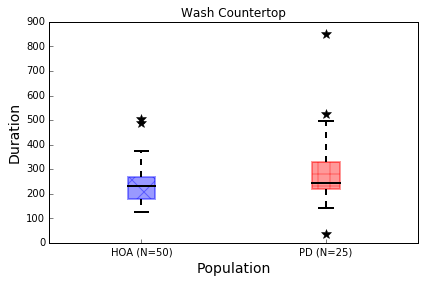

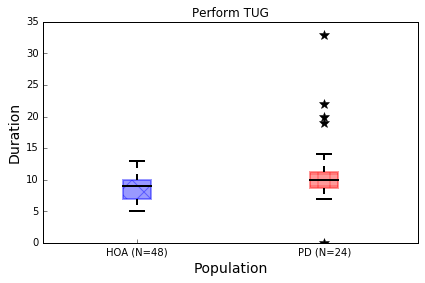

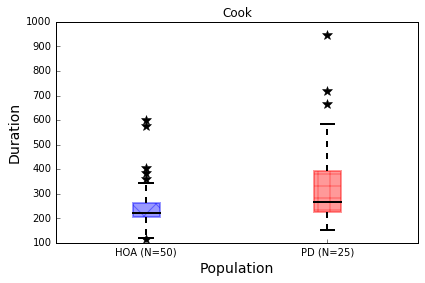

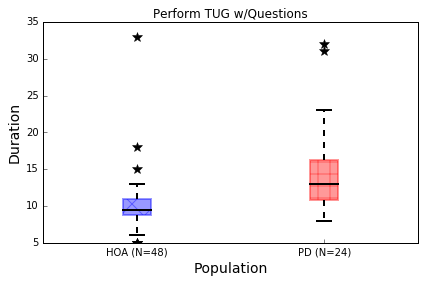

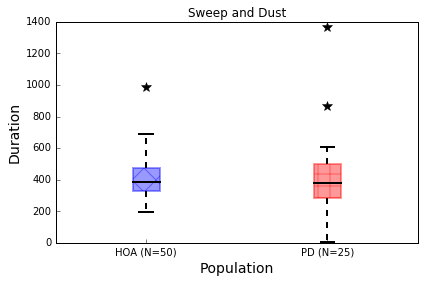

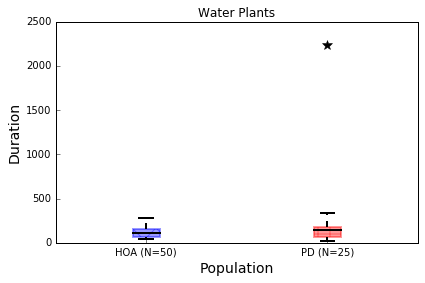

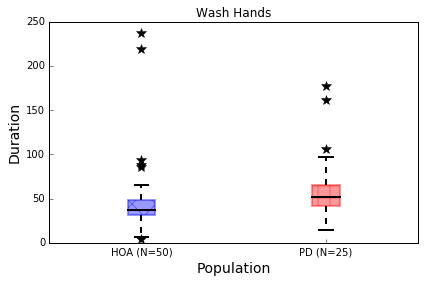

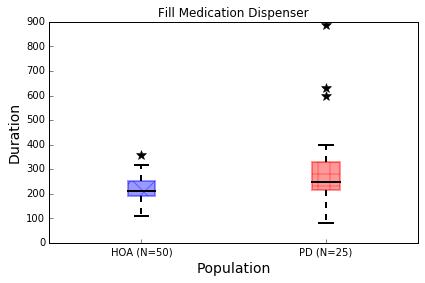

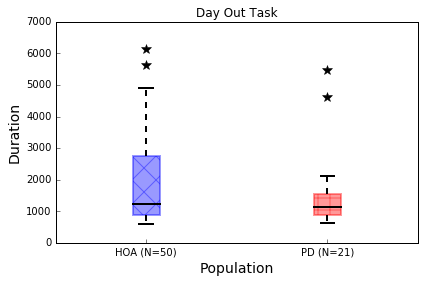

In [52]:
def plot_box_whisker(task_name, distros):
    '''
    
    '''
    colors = ['blue', 'red', 'orange']
    patterns = ('x', '+', '-', '\\', '.', 'o', 'O', '*')
    flierprops = dict(marker='*', markerfacecolor='black', markersize=10, linestyle='none', markeredgecolor='black')
    xticklabs = []
    data = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = task_name

    for pop_name, ser in distros.items():
        xticklabs.append("%s (N=%d)" %(pop_name, len(ser)))
        data.append(ser.astype(np.float).tolist())

    bp = ax.boxplot(data, patch_artist=True, flierprops=flierprops, sym='*')
    ax.set_xticklabels(xticklabs)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    plt.xlabel("Population", fontsize=14)#, fontweight='bold')
    plt.ylabel("Duration", fontsize=14)#, fontweight='bold')
    
    for j, box in enumerate(bp['boxes']):
        box.set(color=colors[j], alpha=.4, edgecolor='black', linewidth=2, hatch=patterns[j])
    
    for whisker in bp['whiskers']:
        whisker.set(color="black", linewidth=2)
    
    for cap in bp['caps']:
        cap.set(color='black', linewidth=2)
    
    for median in bp['medians']:
        median.set(color='black', linewidth=2)
        
    plt.title(title)
    plt.tight_layout()

for task_name, distributions in task_distributions.items():
    plot_box_whisker(task_name, distributions)
plt.show()

#### Histogram Plot w/Normal Curve
Now, as another approach to visualize the data, let's make a histogram for each population. If we assume the data is normal, we can overly a normal distribution probability density function with [`normpdf()`](https://matplotlib.org/api/mlab_api.html#matplotlib.mlab.normpdf) to see how the two populations' normal distributions compare.

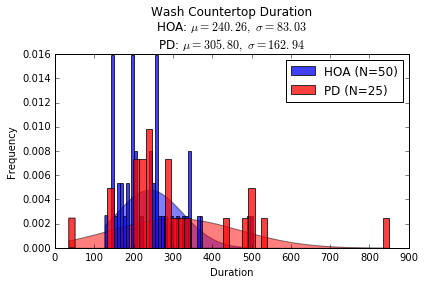

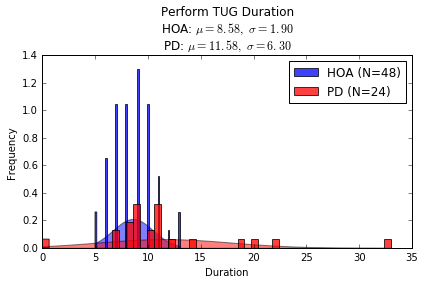

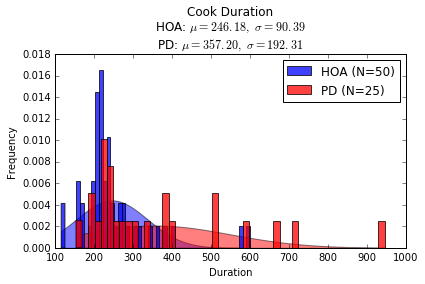

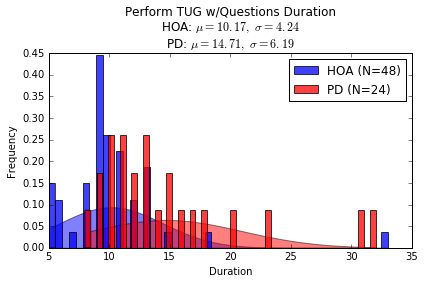

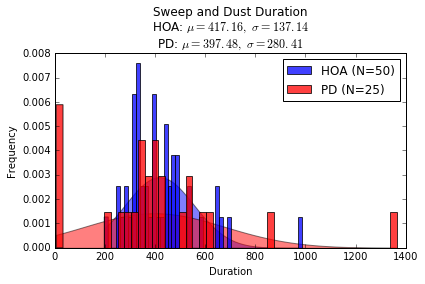

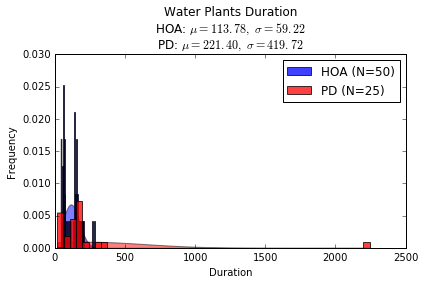

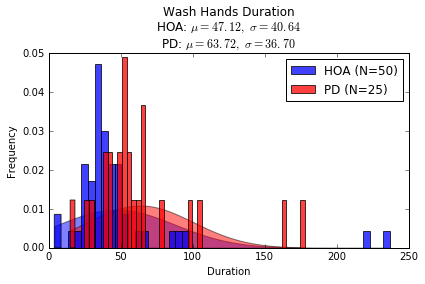

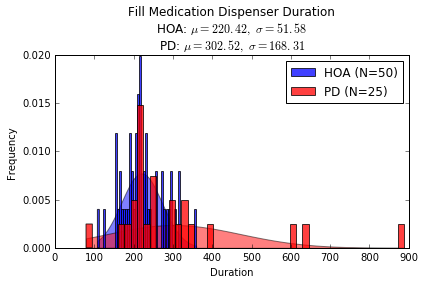

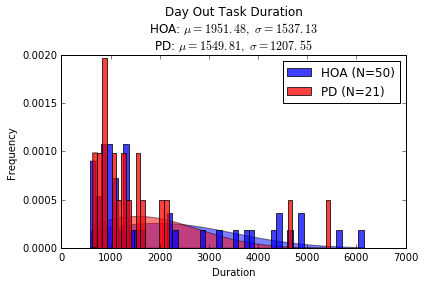

In [53]:
def plot_histogram(task_name, distros):
    '''
    
    '''  
    colors = ['blue', 'red', 'orange']
    i = 0  
    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = task_name + " Duration"
    for pop_name, x in distros.items():
        mu = np.mean(x)
        sigma = np.std(x)
        title += '\n%s: $ \mu=%.2lf,\ \sigma=%.2lf$' %(pop_name, mu, sigma)

        n, bins, patches = ax.hist(x, 50, normed=1, facecolor=colors[i], alpha=0.75, label="%s (N=%d)" %(pop_name, len(x)))
        y = mlab.normpdf(bins, mu, sigma)
        
        rang = np.linspace(np.min(bins), np.max(bins), len(y))
        ax.fill_between(rang, 0, y, facecolor=colors[i], alpha=0.5)
        i += 1
        
    plt.xlabel("Duration")
    plt.ylabel('Frequency')
    plt.title(title)
    plt.tight_layout()
    ax.legend()
    
for task_name, distributions in task_distributions.items():
    plot_histogram(task_name, distributions)
plt.show()

## Summary
In this lesson, we aggregated data to perform subgroup analyses compare Parkinson's disease participants with age-matched, health older adults. We computed age mean and standard deviation for each group (confirming the "age-match") and we visualized each task's duration distribution to more easily compare and contrast the performance of each group. 

It may be interesting to know that the sequence of steps we performed in this lesson recreates the figure used in an IEEE Journal article: [Cook et al., 2015](http://ieeexplore.ieee.org/document/7181652/). Check it out:

<img src="https://raw.githubusercontent.com/gsprint23/aha/master/lessons/figures/pdvis_bhi_figure.png" width="500">